# 5580 Project Helicopter Emergency Transport in Upstate New York
- Jingyi Chen UID:jc2498
- Shuo Feng UID:sf587
- Chuanbo Tang UID:ct648
- Chuyang Zhang UID: cz477

## Import Labraries

In [1]:
import numpy as np
import pandas as pd
import scipy as sc
import scipy.linalg as scl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
import math
from scipy import integrate
%matplotlib inline
from PIL import Image
from haversine import haversine, Unit
import cvxpy as cp
import gurobipy
import warnings
warnings.filterwarnings("ignore")
from matplotlib.offsetbox import AnchoredText

## Data Initialization

In [2]:
def to_df(a): # turns array into pandas dataframe
    df = pd.DataFrame(data    = a[1:,1:] , # values
                    index   = a[1:,0]  , # 1st column as rows
                    columns = a[0,1:]  ) # 1st row as the column names
    df = df.astype('float') # Turn dataframe entries into floats
    return df



heli_info = to_df(np.array([[ '',     'Buffalo', 'Rochester', 'Elmira', 'Ithaca', 'Sayre PA', 'Watertown', 'Syracuse', 'Binghamton', 'Utica', 'Albany',],
                          ['Num' ,    1,          1,   1,1,1,1,1,1,1,1, ],
                          ['Lat' ,   42.9351, 43.3097,42.1128,42.4871,41.9887,42.3856,43.1523,42.1391,43.1432,42.7243,],
                           ['Lon', 78.8985, 77.5771, 76.8021, 76.4916, 76.5129, 71.1857, 76.09616, 75.9244 , 75.2234,73.7475,] ]))


column_names = ['Time','Lat','Lon','Heli avail','Safe to fly','When_to_cancel','chosen heli','CancelDelay','Scene time','Hosp Lat','Hosp Lon','Hosp time','Arrival_Base_Time']
df = pd.DataFrame(0,index=range(0,30000),columns = column_names)
df['chosen heli'] = df['chosen heli'].astype(str)

# heli return update 
heli_update = pd.DataFrame(0, index=range(0,30000),columns = ['Arrival_Base_Time', 'chosen heli'])

hosp_names = np.array(['Sarye','Albany','Syracuse' ,'Rochester','A','B','C','D','E','F'])
hosp_loc = np.array([[41.979 ,76.5155], [42.6526 , 73.7562],[43.0481 ,76.1474], [43.1566 ,77.6088], [42.0898 ,76.8077], [42.0987,75.918], [42.444,76.5019],[42.8864 ,78.8784], [43.1009, 75.2327], [43.9748,75.9108]])

trauma_names = np.asarray(['Sarye','Albany','Syracuse' ,'Rochester'])
trauma_loc = np.array([[41.979 ,76.5155], [42.6526 , 73.7562],[43.0481 ,76.1474], [43.1566 ,77.6088]])                                                                                                                   

small_names = np.array(['A','B','C','D','E','F'])
small_loc = np.array([[42.0898 ,76.8077], [42.0987,75.918], [42.444,76.5019],[42.8864 ,78.8784], [43.1009, 75.2327], [43.9748,75.9108]])                                                                                                                   


In [3]:
# Helicopter number in each base and related base city's Latitude and Longtitude
heli_info

,Buffalo,Rochester,Elmira,Ithaca,Sayre PA,Watertown,Syracuse,Binghamton,Utica,Albany
Num,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.00000,1.0000,1.0000,1.0000
Lat,42.9351,43.3097,42.1128,42.4871,41.9887,42.3856,43.15230,42.1391,43.1432,42.7243
Lon,78.8985,77.5771,76.8021,76.4916,76.5129,71.1857,76.09616,75.9244,75.2234,73.7475


## Data Reference 

In [4]:
data = pd.read_csv('ProjectData.csv')

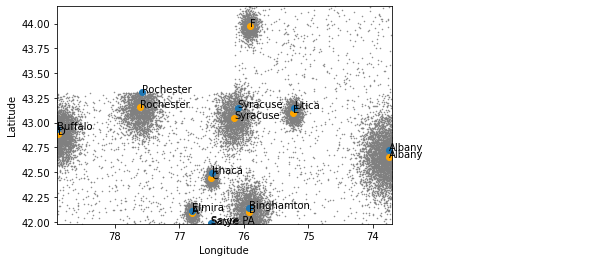

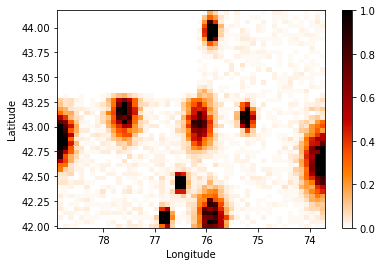

In [5]:
# plot call location and hospital location and base location
lat = data['Lat'] 
lon = data['Lon']
min_lat = min(lat)
max_lat = max(lat) 
min_lon = min(lon)
max_lon = max(lon)

#scatter plot
fig = plt.figure() 
ax = fig.gca()
plt.scatter(lon,lat,marker='.', c = 'grey',s = 1)

plt.axis([max_lon,min_lon,min_lat,max_lat]) 
plt.xlabel("Longitude") 
plt.ylabel("Latitude")

# plot hosp location
for i in range(len(hosp_loc)):
    plt.scatter(hosp_loc[i][1], hosp_loc[i][0], marker="o", c='orange')
for i, txt in enumerate(hosp_names):
    plt.annotate(txt, (hosp_loc[i][1], hosp_loc[i][0]))


# plot base location
y = [42.9351, 43.3097,42.1128,42.4871,41.9887,42.3856,43.1523,42.1391,43.1432,42.7243]
z = [78.8985, 77.5771, 76.8021, 76.4916, 76.5129, 71.1857, 76.09616, 75.9244 , 75.2234,73.7475]
n = ['Buffalo', 'Rochester', 'Elmira', 'Ithaca', 'Sayre PA', 'Watertown', 'Syracuse', 'Binghamton', 'Utica', 'Albany']

plt.scatter(z, y)

for i, txt in enumerate(n):
    plt.annotate(txt, (z[i], y[i]))
    

plt.show()


#probability plot
plt.hist2d(lon,lat,bins = 50, range = [[min_lon ,max_lon],[min_lat,max_lat]], density=True,cmap= 'gist_heat_r', vmin=0,vmax =1)


plt.axis([max_lon,min_lon,min_lat,max_lat]) 
plt.xlabel("Longitude") 
plt.ylabel("Latitude")
plt.colorbar()
plt.show()

In [6]:
# Caculate the CallArrival rate for 24 hours from reference data
time = data['Time'] #count the day
days = np.ceil(time/24)
counts = np.zeros(24)
for i in range(data.shape[0]):
    interval = int(time[i]) % 24
# increment counter for interval arrival fell in
    counts[interval] += 1
# divide counts by interval width∗num days to get
#average hourly arrivals in each interval (which is the MLE) 
CallArrivalRate= counts/(max(days))
CallArrivalRate

array([0.72252747, 0.61813187, 0.37362637, 0.31868132, 0.26648352,
       0.27747253, 0.48901099, 0.77747253, 1.69505495, 2.74725275,
       3.19230769, 3.71978022, 3.96428571, 3.67307692, 3.81318681,
       3.68406593, 3.56043956, 3.1978022 , 3.05494505, 2.28021978,
       1.3956044 , 1.17032967, 0.88186813, 0.81318681])

## Simulation Events

### a) CallArrival

In [7]:
def CallArrival(t,i,State):
# generate call arrival
    t_a = np.random.exponential(1/(CallArrivalRate[int(t%24)]), size=1)
    df['Time'].loc[i] = t+t_a
    t = t+t_a

# generate cancellation time

    t_c = np.random.exponential(4.87, size=1)
    
# generate call location
    index = np.random.choice(range(0,len(data)))
    #call_locations = list(data[['Lat','Lon']])
    #call_location = np.random.choice(call_locations)
    df['Lat'].iloc[i] = data['Lat'].loc[index]
    df['Lon'].iloc[i] = data['Lon'].loc[index]
    call_location = [df['Lat'].iloc[i], df['Lon'].iloc[i]]
    
# check if available helicopter within range
    avai_heli = {}
    city_names = heli_info.columns
    for c in city_names:
        dist = haversine(call_location, [heli_info[c].loc['Lat'],heli_info[c].loc['Lon']], unit=Unit.KILOMETERS)

        if(heli_info[c].loc['Num'] != 0) & (dist <= 180):
            avai_heli[c]=dist

    if(len(avai_heli)==0):
        df['Heli avail'].loc[i] = 0
        
    else:
        df['Heli avail'].loc[i] = 1
        chosen_heli = min(avai_heli, key=avai_heli.get)
        #df['chosen_heli'].loc[i] = chosen_heli
        chosen_helis.append(chosen_heli)
        df['chosen heli'].loc[i] = chosen_heli
        
        # add new call to the list of that helicopter
        active_list.append(i)
#         print(active_list)
        # set HeliIndex for the new call to that helicopter
        HeliIndex = chosen_heli
        # update helicopter states to AwaitingClearance
        State = 'AwaitingClearance'
        # set CallIndex point to the call
        CallIndex.append(i)
        # generate an HDDelayTime t_d
        t_d = np.random.triangular(5, 7, 10, size=1)/60
#         print('cancel',t_c)
#         print('hd',t_d)
        if t + t_d < t + t_c:
            # schedule call finish event as HD event at t + t_d
            CallFinishesAtHD(t,t_c,t_d,i,State,destination, chosen_heli,avai_heli,heli_update)
        else:
#             print('cancel before HD')
            CallCancelled(t,t_c,t_d,0,State,i,destination,chosen_heli,avai_heli, heli_update)
  
    # generate next CallArrical event
    return t

### b) CallCancelled

In [8]:
def CallCancelled(t,t_c,t_d,t_prep,State,i,destination,chosen_heli,avai_heli,heli_update):   #哪里判断30

    if (State == 'AwaitingClearance') or (State == 'PrepForCall'):
        if State == 'AwaitingClearance':
            df['When_to_cancel'].loc[i]='Cancel_durning_HD'
        if State == 'PrepForCall':
            df['When_to_cancel'].loc[i]='Cancel_durning_Prep'
            
            
        df['CancelDelay'].loc[i] = t_c
        
        State = 'AtBase'
        active_list.remove(i)
    if State == 'OnWayToScene':
        df['When_to_cancel'].loc[i]='Cancel_durning_to_Scene'
        State == 'OnWayToBase'
        # arrival time as base use helicopter destination field to determine its location at time of cancellation 没懂
        t_arrival_base = (t + t_c  + t_c - t_d - t_prep)
        HeliArrivesAtBase(t_arrival_base,chosen_heli, heli_update) 
        df['CancelDelay'].loc[i] = t_c
        active_list.remove(i)

### c) CallFinishesAtHD

In [9]:
def CallFinishesAtHD(t,t_c,t_d,i,State,destination,chosen_heli,avai_heli,heli_update):
    
    prob_safe=np.random.uniform()
#     print(prob_safe)
    if prob_safe<0.1:
#         print('unsafe')
        df['Safe to fly'].loc[i]=0
        State = 'AtBase'
        active_list.remove(i)
    else:
#         print('Safe')
        df['Safe to fly'].loc[i]=1
        # helicopter available at base - 1
        heli_info[chosen_heli].loc['Num'] = heli_info[chosen_heli].loc['Num']-1
        
        State='PrepForCall'
        t_prep=np.random.triangular(5, 7.5, 10, size=1)/60

        if t_c<t_d+t_prep:
            CallCancelled(t,t_c,t_d,t_prep,State,i,destination,chosen_heli,avai_heli, heli_update)
        else:
            HeliDepartsForCall(t,t_c,t_d,t_prep,State,i,destination, chosen_heli,avai_heli,heli_update)
            

### d) HeliDepartsForCall

In [10]:
def HeliDepartsForCall(t,t_c,t_d,t_prep,State,i,destination,chosen_heli,avai_heli, heli_update):
    state='OnWayToScene'
    #time arrival to Scene:
    t_A=avai_heli[chosen_heli]/160
    if t_c<t_d+t_prep+t_A:
        CallCancelled(t,t_c,t_d,t_prep,State,i,destination,chosen_heli,avai_heli,heli_update)
    else:
        HeliArrivesAtScene(t,t_c,t_d,t_prep,t_A,State,i,destination,chosen_heli,avai_heli, heli_update)      

### e) HeliArrivesAtScene

In [11]:
def HeliArrivesAtScene(t,t_c,t_d,t_prep,t_A,State,i,destination,chosen_heli,avai_heli, heli_update):
    t_s = np.random.gamma(2.95, scale=0.12, size=1)
    df['Scene time'].loc[i] = t_s
    response_time.append(t_d+t_prep+t_A)
    State = 'AtScene'
    HeliDepartsFromScene(t,t_c,t_d,t_prep,t_A,t_s,State,i,destination,chosen_heli,avai_heli,heli_update)

### f) HeliDepartsFromScene

In [12]:
def HeliDepartsFromScene(t,t_c,t_d,t_prep,t_A,t_s,State,i,destination,chosen_heli, avai_heli, heli_update):
    # whether nearest hosp is trauma
    all_dist = []
    for j in range(len(hosp_loc)):
        dist = haversine(hosp_loc[j], [df['Lat'].iloc[i], df['Lon'].iloc[i]])
        all_dist.append(dist)
    index = np.argmin(all_dist)
    if hosp_names[index] in trauma_names:
        destination = hosp_names[index]
        distance = min(all_dist)
        # update df
        df['Hosp Lat'].iloc[i] = hosp_loc[index][0]
        df['Hosp Lon'].iloc[i] = hosp_loc[index][1]

    else:
        # cloest is not trauma
    
        # outcome to trauma
        outcome = np.random.binomial(1, 0.193, size=1)
        if outcome == 1:
        
            # go to trauma
        
            trauma_dist = []
            for j in range(len(trauma_loc)):
                dist = haversine(trauma_loc[j], [df['Lat'].iloc[i], df['Lon'].iloc[i]])
                trauma_dist.append(dist)
            index = np.argmin(trauma_dist)
            distance = min(trauma_dist)
            destination = trauma_names[index]
             # update df
            df['Hosp Lat'].iloc[i] = trauma_loc[index][0]
            df['Hosp Lon'].iloc[i] = trauma_loc[index][1]
        else:
            # go to nearest small hosp
            small_dist = []
            for j in range(len(small_loc)):
                dist = haversine(small_loc[j], [df['Lat'].iloc[i], df['Lon'].iloc[i]])
                small_dist.append(dist)
            index = np.argmin(small_dist)
            distance = min(small_dist)
            destination = small_names[index]
             # update df
            df['Hosp Lat'].iloc[i] = small_loc[index][0]
            df['Hosp Lon'].iloc[i] = small_loc[index][1]
    # time that helicopter arrives at its destination t_h
    t_h = distance/160
 
    State = 'OnWayToHosp'
    HeliArrivesAtHosp(t,t_c,t_d,t_prep,t_A,t_s,t_h,State,i,destination,chosen_heli, avai_heli,heli_update)
    

### g) HeliArrivesAtHosp

In [13]:
def HeliArrivesAtHosp(t,t_c,t_d,t_prep,t_A,t_s,t_h,State,i,destination,chosen_heli,avai_heli, heli_update):
    State='AtHosp'
    #t_H is the time spent in hosp
    t_H=np.random.gamma(2.91, scale=0.17, size=1)
    df['Hosp time'].loc[i] = t_H
    HeliDepartsHosp(t,t_c,t_d,t_prep,t_A,t_s,t_h,t_H,State,i,destination,chosen_heli,avai_heli, heli_update)

### h) HeliDepartsHosp

In [14]:
def HeliDepartsHosp(t,t_c,t_d,t_prep,t_A,t_s,t_h,t_H,State,i,destination,chosen_heli,avai_heli, heli_update):
    active_list.remove(i)
    State='OnWayToBase'
    index = list(hosp_names).index(destination)
    dist = haversine(hosp_loc[index], [heli_info[chosen_heli].loc['Lat'], heli_info[chosen_heli].loc['Lon']]) 
    t_arrival_to_base=  dist/160 + t_d + t_prep + t_A + t_s + t_h + t_H
    t_arrival_base_global=t+t_arrival_to_base
    HeliArrivesAtBase(t_arrival_base_global,chosen_heli,avai_heli, heli_update)

### i) HeliArrivesAtBase

In [15]:
def HeliArrivesAtBase(t_arrival_base_global,chosen_heli,avai_heli, heli_update):
    State='AtBase'
    df['Arrival_Base_Time'].loc[i]=t_arrival_base_global
    
    heli_update['Arrival_Base_Time'].loc[i] = t_arrival_base_global
    heli_update['chosen heli'].loc[i] = chosen_heli

## Testing -- only for senario

In [63]:
active_list = []
event = []
HeliIndex = []
CallIndex = []
State = ''
destination = ''
response_time=[]
chosen_helis = []
all_response = []
all_selection=[]


df = pd.DataFrame(0,index=range(0,30000),columns = column_names)
df['chosen heli'] = df['chosen heli'].astype(str)

# heli return update 
heli_update = pd.DataFrame(0, index=range(0,30000),columns = ['Arrival_Base_Time', 'chosen heli'])
heli_info = to_df(np.array([[ '',     'Buffalo', 'Rochester', 'Elmira', 'Ithaca', 'Sayre PA', 'Watertown', 'Syracuse', 'Binghamton', 'Utica', 'Albany',],
                          ['Num' ,    10,          10,   10,10,10,10,10,10,10,10, ],
                          ['Lat' ,   42.9351, 43.3097,42.1128,42.4871,41.9887,42.3856,43.1523,42.1391,43.1432,42.7243,],
                           ['Lon', 78.8985, 77.5771, 76.8021, 76.4916, 76.5129, 71.1857, 76.09616, 75.9244 , 75.2234,73.7475,] ]))

t=0
i=0
while t<24*14:
    
        
    t = CallArrival(t,i,State)

    # update return heli update
    heli_copy = heli_update.copy()
    heli_copy = heli_copy.loc[(heli_copy!=0).any(axis=1)]
    heli_copy = heli_copy.sort_values(by=['Arrival_Base_Time'], ascending=True)

    if len(heli_copy) != 0:
        if (t > heli_copy['Arrival_Base_Time'].iloc[0]):
            heli_info[heli_copy['chosen heli'].iloc[0]].loc['Num'] += 1
            time1 = heli_copy['Arrival_Base_Time'].iloc[0]
#             print(time1)
            heli_update = heli_update[heli_update['Arrival_Base_Time'] != time1]     
    i=i+1
df=df[df.Lat!=0]
df

averaged_response_time=np.mean(response_time)

df

,Time,Lat,Lon,Heli avail,Safe to fly,When_to_cancel,chosen heli,CancelDelay,Scene time,Hosp Lat,Hosp Lon,Hosp time,Arrival_Base_Time
0,0.612752,43.230674,77.621822,1,1,0,Rochester,0.0,0.579368,43.1566,77.6088,0.380506,2.037656
1,0.857704,42.648508,73.707974,1,1,0,Albany,0.0,0.678111,42.6526,73.7562,0.466234,2.357808
2,1.269092,42.756069,74.109690,1,1,0,Albany,0.0,0.313184,42.6526,73.7562,0.650111,2.911938
3,4.967406,43.124040,77.677367,1,1,0,Rochester,0.0,0.365565,43.1566,77.6088,0.293272,6.178384
4,5.560549,42.558912,73.945696,1,1,0,Albany,0.0,0.703721,42.6526,73.7562,0.513462,7.370669
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,333.676606,43.177758,75.228184,1,1,0,Utica,0.0,0.111026,43.1009,75.2327,0.538840,334.669472
596,333.825300,42.844291,76.072929,1,0,0,Ithaca,0.0,0.000000,0.0000,0.0000,0.000000,0.000000
597,333.893649,42.114537,75.863179,1,1,0,Binghamton,0.0,0.435186,41.9790,76.5155,0.399139,335.668382
598,335.158242,42.438164,75.963073,1,1,0,Binghamton,0.0,0.235183,41.9790,76.5155,0.437140,337.020616


## Simulation Part

### One Senario's Simulation

In [16]:
def one_senario_simulation(heli_info):
    
    #Initialization of each active call state
    active_list = []
    event = []
    HeliIndex = []
    CallIndex = []
    State = ''
    destination = ''
    response_time=[]
    chosen_helis = []
    

    #Intilization of each heli return update 
    heli_update = pd.DataFrame(0, index=range(0,30000),columns = ['Arrival_Base_Time', 'chosen heli'])
    
    # Number of total helicopters used in this senario
    heli_total_num=heli_info.loc['Num'].sum()
    
    #Initilization of performance measures
    averaged_response_time=[]
    percentage_of_calls_dispatched=[]
    response_fraction=[]
    Utlization_of_helicopter=[]

    #Intialize global time and number of call
    t=0
    i=0
    
    #Start the simulation process
    for b in range(1,17):
        #Initilization of result data 
        df = pd.DataFrame(0,index=range(0,30000),columns = column_names)
        df['chosen heli'] = df['chosen heli'].astype(str)
        while t<24*14*b:#Each batch have 2 weeks(14days)

            t = CallArrival(t,i,State)

            # update return heli update
            heli_copy = heli_update.copy()
            heli_copy = heli_copy.loc[(heli_copy!=0).any(axis=1)]
            heli_copy = heli_copy.sort_values(by=['Arrival_Base_Time'], ascending=True)

            if len(heli_copy) != 0:
                if (t > heli_copy['Arrival_Base_Time'].iloc[0]):

                    heli_info[heli_copy['chosen heli'].iloc[0]].loc['Num'] += 1
                    time1 = heli_copy['Arrival_Base_Time'].iloc[0]
                    heli_update = heli_update[heli_update['Arrival_Base_Time'] != time1]     
            i=i+1
        # Remove those Nan value rows
        df=df[df.Lat!=0]

        if b!=1:#let batch 1 as the initial transient phase, so we don't want this batch information
            #Performance Measures and Objective
            averaged_response_time_batch=np.mean(response_time)

            #percentage_of_calls_dispatched 
            percentage_of_calls_dispatched_batch=1-len(df[(df['Safe to fly']==0 )| (df['Heli avail']==0)])/len(df)

            #response_fraction
            response_fraction_batch=len(response_time)/len(df)

            #Utlization_of_helicopter
            Utlization_of_helicopter_batch=len(df[df['Hosp time']!=0])/14*heli_total_num
            
            #Get all batch measures      
            averaged_response_time.append(averaged_response_time_batch)
            percentage_of_calls_dispatched.append(percentage_of_calls_dispatched_batch)
            response_fraction.append(response_fraction_batch)
            Utlization_of_helicopter.append(Utlization_of_helicopter_batch)
    # Get measures' mean of all batch         
    averaged_response_time=np.mean(averaged_response_time)
    percentage_of_calls_dispatched=np.mean(percentage_of_calls_dispatched)
    response_fraction=np.mean(response_fraction)
    Utlization_of_helicopter=np.mean(Utlization_of_helicopter)
    return averaged_response_time,percentage_of_calls_dispatched,response_fraction,Utlization_of_helicopter

## Simulation for different senarios

### Create num for each base

In [81]:
base_heli=pd.DataFrame(1,index=range(0,10),columns = heli_info.columns)
for i in range(10):
    base_heli.iloc[i,i]=2
base_heli

,Buffalo,Rochester,Elmira,Ithaca,Sayre PA,Watertown,Syracuse,Binghamton,Utica,Albany
0,2,1,1,1,1,1,1,1,1,1
1,1,2,1,1,1,1,1,1,1,1
2,1,1,2,1,1,1,1,1,1,1
3,1,1,1,2,1,1,1,1,1,1
4,1,1,1,1,2,1,1,1,1,1
5,1,1,1,1,1,2,1,1,1,1
6,1,1,1,1,1,1,2,1,1,1
7,1,1,1,1,1,1,1,2,1,1
8,1,1,1,1,1,1,1,1,2,1
9,1,1,1,1,1,1,1,1,1,2


In [ ]:
all_response_time = []
all_percentage_of_calls_dispatched=[]
all_response_fraction=[]
all_Utlization_of_helicopter=[]


for k in range(len(base_heli)):
    heli_info.loc['Num']=base_heli.iloc[k,:]
    ART,PD,RF,UH=one_senario_simulation(heli_info)
    
    all_response.append(averaged_response_time)
    all_response_time = []
    all_percentage_of_calls_dispatched=[]
    all_response_fraction=[]
    all_Utlization_of_helicopter=[]
    
    
print('all Bases optimization')
base_heli['averaged_response_time'] = all_response
base_heli = base_heli.sort_values(by = ['averaged_response_time'], ascending=True)
base_heli    


### All Bases Selection

In [ ]:

all_response = []
all_selection=[]


heli_info = to_df(np.array([[ '',     'Buffalo', 'Rochester', 'Elmira', 'Ithaca', 'Sayre PA', 'Watertown', 'Syracuse', 'Binghamton', 'Utica', 'Albany',],
                          ['Num' ,    10,          10,   10,10,10,10,10,10,10,10, ],
                          ['Lat' ,   42.9351, 43.3097,42.1128,42.4871,41.9887,42.3856,43.1523,42.1391,43.1432,42.7243,],
                           ['Lon', 78.8985, 77.5771, 76.8021, 76.4916, 76.5129, 71.1857, 76.09616, 75.9244 , 75.2234,73.7475,] ]))


# from plot, try several choice combination of base location and num of heli assigned 
# bufflo, rochester, syracuse, Binghamton, Albany are busy scene
#n = ['Buffalo', 'Rochester', 'Elmira', 'Ithaca', 'Sayre PA', 'Watertown', 'Syracuse', 'Binghamton', 'Utica', 'Albany']

all_selection.append([2,2,1,1,1,1,1,1,1,1])
all_selection.append([2,1,1,1,1,1,2,1,1,1])# *********
all_selection.append([2,1,1,1,1,1,1,2,1,1])
all_selection.append([2,1,1,1,1,1,1,1,1,2])

all_selection.append([2,2,0,0,1,1,2,2,1,1])
all_selection.append([2,2,0,0,1,1,1,2,1,2]) # **********
all_selection.append([2,2,0,0,1,1,2,1,1,2])

all_selection.append([2,2,0,0,0,0,2,2,2,2])
all_selection.append([2,3,0,0,0,0,1,2,2,2])
all_selection.append([2,2,0,0,0,0,4,2,2,1]) # *************
all_selection.append([2,2,0,0,0,0,5,2,1,1])

# based on above simulation response time, slightly alter  
all_selection.append([2,2,0,0,0,2,1,2,1,2])
all_selection.append([2,2,0,0,0,1,2,2,1,2]) 
all_selection.append([2,2,0,0,0,0,3,2,1,2]) 
all_selection.append([2,2,0,0,0,1,1,3,0,3])

all_selection.append([2,2,0,0,0,1,3,2,2,1])
all_selection.append([2,2,0,0,0,0,3,3,2,1])
all_selection.append([2,2,0,0,0,0,4,2,0,2])

all_selection.append([3,2,1,0,0,1,2,1,1,1])
all_selection.append([2,3,1,0,0,1,2,1,1,1])
all_selection.append([3,2,1,0,0,1,2,1,0,1])
all_selection.append([3,0,0,1,1,1,3,1,1,1])

for i in range(len(all_selection)):
    for j in range(len(heli_info.columns)):
        heli_info.iloc[0,j] = all_selection[i][j]
        
    active_list = []
    event = []
    HeliIndex = []
    CallIndex = []
    State = ''
    destination = ''
    response_time=[]
    chosen_helis = []

    df = pd.DataFrame(0,index=range(0,30000),columns = column_names)
    df['chosen heli'] = df['chosen heli'].astype(str)

    # heli return update 
    heli_update = pd.DataFrame(0, index=range(0,30000),columns = ['Arrival_Base_Time', 'chosen heli'])

    t=0
    i=0
    while t<24*14:
        
        t = CallArrival(t,i,State)

        # update return heli update
        heli_copy = heli_update.copy()
        heli_copy = heli_copy.loc[(heli_copy!=0).any(axis=1)]
        heli_copy = heli_copy.sort_values(by=['Arrival_Base_Time'], ascending=True)

        if len(heli_copy) != 0:
            if (t > heli_copy['Arrival_Base_Time'].iloc[0]):
                
                heli_info[heli_copy['chosen heli'].iloc[0]].loc['Num'] += 1
                time1 = heli_copy['Arrival_Base_Time'].iloc[0]
#                    print(time1)
                heli_update = heli_update[heli_update['Arrival_Base_Time'] != time1]     
        i=i+1
    df=df[df.Lat!=0]
    averaged_response_time=np.mean(response_time)
    all_response.append(averaged_response_time)
    
print('all Bases optimization')
base_all_df = pd.DataFrame(all_selection, columns = ['Buffalo', 'Rochester', 'Elmira', 'Ithaca', 'Sayre PA', 'Watertown', 'Syracuse', 'Binghamton', 'Utica', 'Albany'])
base_all_df['averaged_response_time'] = all_response
base_all_df = base_all_df.sort_values(by = ['averaged_response_time'], ascending=True)
base_all_df

### 5 Bases Selection
 choose bufflo, rochester, syracuse, Binghamton, Albany, are busy scene

In [ ]:
all_response = []
all_selection=[]


heli_info = to_df(np.array([[ '',     'Buffalo', 'Rochester', 'Elmira', 'Ithaca', 'Sayre PA', 'Watertown', 'Syracuse', 'Binghamton', 'Utica', 'Albany',],
                          ['Num' ,    10,          10,   10,10,10,10,10,10,10,10, ],
                          ['Lat' ,   42.9351, 43.3097,42.1128,42.4871,41.9887,42.3856,43.1523,42.1391,43.1432,42.7243,],
                           ['Lon', 78.8985, 77.5771, 76.8021, 76.4916, 76.5129, 71.1857, 76.09616, 75.9244 , 75.2234,73.7475,] ]))


# from plot, try several choice combination of base location and num of heli assigned 
# bufflo, rochester, syracuse, Binghamton, Albany are busy scene
#n = ['Buffalo', 'Rochester', 'Elmira', 'Ithaca', 'Sayre PA', 'Watertown', 'Syracuse', 'Binghamton', 'Utica', 'Albany']
all_selection.append([3,3,0,0,0,0,2,2,0,2])
all_selection.append([2,2,0,0,0,0,3,3,0,2])
all_selection.append([2,3,0,0,0,0,3,2,0,2])
all_selection.append([3,2,0,0,0,0,2,3,0,2])
all_selection.append([2,3,0,0,0,0,2,2,0,3])
all_selection.append([3,2,0,0,0,0,2,2,0,3])

all_selection.append([4,2,0,0,0,0,2,2,0,2])
all_selection.append([2,4,0,0,0,0,2,2,0,2])
all_selection.append([2,2,0,0,0,0,4,2,0,2])
all_selection.append([2,2,0,0,0,0,2,4,0,2])
all_selection.append([2,2,0,0,0,0,2,2,0,4])

# based on above simulation response time, slightly alter  
all_selection.append([4,1,0,0,0,0,3,2,0,2])
all_selection.append([3,3,0,0,0,0,2,2,0,2])
all_selection.append([3,1,0,0,0,0,4,2,0,2])
all_selection.append([3,1,0,0,0,0,3,3,0,2])
all_selection.append([3,1,0,0,0,0,3,2,0,3])
all_selection.append([3,1,0,0,0,0,4,1,0,3])
all_selection.append([4,1,0,0,0,0,3,2,0,2])




for i in range(len(all_selection)):
    for j in range(len(heli_info.columns)):
        heli_info.iloc[0,j] = all_selection[i][j]
        
    active_list = []
    event = []
    HeliIndex = []
    CallIndex = []
    State = ''
    destination = ''
    response_time=[]
    chosen_helis = []

    df = pd.DataFrame(0,index=range(0,30000),columns = column_names)
    df['chosen heli'] = df['chosen heli'].astype(str)

    # heli return update 
    heli_update = pd.DataFrame(0, index=range(0,30000),columns = ['Arrival_Base_Time', 'chosen heli'])

    t=0
    i=0
    while t<24*14:
        
        t = CallArrival(t,i,State)

        # update return heli update
        heli_copy = heli_update.copy()
        heli_copy = heli_copy.loc[(heli_copy!=0).any(axis=1)]
        heli_copy = heli_copy.sort_values(by=['Arrival_Base_Time'], ascending=True)

        if len(heli_copy) != 0:
            if (t > heli_copy['Arrival_Base_Time'].iloc[0]):
                
                heli_info[heli_copy['chosen heli'].iloc[0]].loc['Num'] += 1
                time1 = heli_copy['Arrival_Base_Time'].iloc[0]
#                    print(time1)
                heli_update = heli_update[heli_update['Arrival_Base_Time'] != time1]     
        i=i+1
    df=df[df.Lat!=0]
    averaged_response_time=np.mean(response_time)
    all_response.append(averaged_response_time)

print('5 Bases optimization')
base5_df = pd.DataFrame(all_selection, columns = ['Buffalo', 'Rochester', 'Elmira', 'Ithaca', 'Sayre PA', 'Watertown', 'Syracuse', 'Binghamton', 'Utica', 'Albany'])
base5_df['averaged_response_time'] = all_response
base5_df = base5_df.sort_values(by = ['averaged_response_time'], ascending=True)
base5_df